# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers





In [0]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [0]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [20]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [22]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [23]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)       

In [0]:
# 第三步編譯
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [0]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [26]:
a=510
a/=255
a

2.0

In [28]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, 
                        y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data = (x_test, y_test),
                        shuffle = True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                zca_epsilon=1e-06,  # epsilon for ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                # randomly shift images horizontally (fraction of total width)
                width_shift_range=0.1,
                # randomly shift images vertically (fraction of total height)
                height_shift_range=0.1,
                shear_range=0.,  # set range for random shear
                zoom_range=0.,  # set range for random zoom
                channel_shift_range=0.,  # set range for random channel shifts
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                cval=0.,  # value used for fill_mode = "constant"
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,  # randomly flip images
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history = model.fit(x_train, 
                        y_train,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data = (x_test, y_test),
                        shuffle = True)   

'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
''' 

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 234s 5ms/step - loss: 0.5305 - acc: 0.8147 - val_loss: 0.6830 - val_acc: 0.7713
Epoch 2/20
50000/50000 [==============================] - 235s 5ms/step - loss: 0.5201 - acc: 0.8173 - val_loss: 0.6471 - val_acc: 0.7846
Epoch 3/20
50000/50000 [==============================] - 235s 5ms/step - loss: 0.5134 - acc: 0.8201 - val_loss: 0.6470 - val_acc: 0.7811
Epoch 4/20
50000/50000 [==============================] - 235s 5ms/step - loss: 0.5048 - acc: 0.8239 - val_loss: 0.6510 - val_acc: 0.7820
Epoch 5/20
50000/50000 [==============================] - 234s 5ms/step - loss: 0.5061 - acc: 0.8212 - val_loss: 0.6816 - val_acc: 0.7767
Epoch 6/20
50000/50000 [==============================] - 235s 5ms/step - loss: 0.4952 - acc: 0.8271 - val_loss: 0.6791 - val_acc: 0.7754
Epoch 7/20
50000/50000 [==============================] - 235s 5ms/step - loss: 0.4893

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

In [31]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 9s 895us/step
Test loss: 0.6884077634811402
Test accuracy: 0.7877


In [32]:
#    第六步：輸出
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)


result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)


 test set 

 The test loss is %f  [0.68840775847435, 0.7876999986171722]


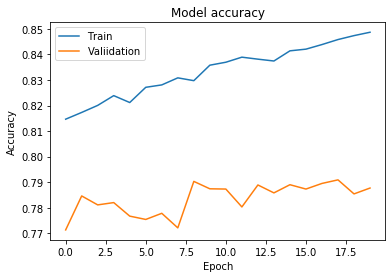

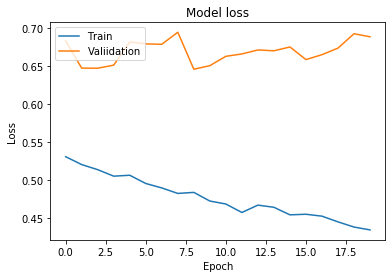

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad,value_and_grad,grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest

In [35]:
# Objective function: the Beale function

f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

z = f(x, y)
minima = np.array([3., .5])
f(*minima)

0.0

In [36]:
minima_ = minima.reshape(-1, 1)
minima_

f(*minima_)

array([0.])

In [0]:
def target_func(weights):
    x,y = weights
    return f(x,y)

# Adam Optimizer

In [0]:
class Adam:
    def __init__(self, loss, weights, lr=0.001, beta1=0.9, beta2=0.999, epislon=1e-8):
        self.loss = loss
        self.theta = weights
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epislon = epislon
        self.get_gradient = grad(loss)
        self.m = 0
        self.v = 0
        self.t = 0

    def minimize_raw(self):
        self.t += 1
        g = self.get_gradient(self.theta)
        self.m = self.beta1 * self.m + (1 - self.beta1) * g
        self.v = self.beta2 * self.v + (1 - self.beta2) * (g * g)
        self.m_hat = self.m / (1 - self.beta1 ** self.t)
        self.v_hat = self.v / (1 - self.beta2 ** self.t)
        self.theta -= self.lr * self.m_cat / (self.v_cat ** 0.5 + self.epislon)

    def minimize(self):
        self.t += 1
        g = self.get_gradient(self.theta)
        lr = self.lr * (1 - self.beta2 ** self.t) ** 0.5 / (1 - self.beta1 ** self.t)
        self.m = self.beta1 * self.m + (1 - self.beta1) * g
        self.v = self.beta2 * self.v + (1 - self.beta2) * (g * g)
        self.theta -= lr * self.m / (self.v ** 0.5 + self.epislon)

    def minimize_trace(self, path=[]):
        self.t += 1
        g = self.get_gradient(self.theta)
        lr = self.lr * (1 - self.beta2 ** self.t) ** 0.5 / (1 - self.beta1 ** self.t)
        self.m = self.beta1 * self.m + (1 - self.beta1) * g
        self.v = self.beta2 * self.v + (1 - self.beta2) * (g * g)
        self.theta -= lr * self.m / (self.v ** 0.5 + self.epislon)
        path.append(np.copy(self.theta))

In [40]:
EPOCHS = 3000
SHOW_STEPS = 100
PRECISION = 1e-8
weights = np.array([1., 1.5])
path_trace = [np.copy(weights)]
adam = Adam(target_func, weights, lr=0.01)
print("start to optimize EPOCHS:{}".format(EPOCHS))
progress_step = EPOCHS // SHOW_STEPS

for i in range(EPOCHS):
    if i % progress_step == 0:
        loss_value = adam.loss(adam.theta)
        print("times:{} weights:{} loss:{}".format(i, adam.theta, loss_value))
        if loss_value < PRECISION:
            print("loss:{} is less than precision:{}, finish!".format(loss_value, PRECISION))
            break
    adam.minimize_trace(path_trace)
print("\nfinal weights:{} loss:{}".format(adam.theta, adam.loss(adam.theta)))

start to optimize EPOCHS:3000
times:0 weights:[1.  1.5] loss:41.25
times:30 weights:[0.7371867  1.22939503] loss:20.299015115677488
times:60 weights:[0.60591868 1.04849877] loss:15.060862617226
times:90 weights:[0.58632034 0.91842752] loss:12.981397656153064
times:120 weights:[0.6502342  0.80472928] loss:11.321903656324578
times:150 weights:[0.78098643 0.69414189] loss:9.42760928272687
times:180 weights:[0.95890658 0.58512322] loss:7.2900861448751595
times:210 weights:[1.15977446 0.48274852] loss:5.207435732865861
times:240 weights:[1.36076875 0.39347367] loss:3.479710603481422
times:270 weights:[1.54570617 0.32136353] loss:2.228035884986305
times:300 weights:[1.70612102 0.26732981] loss:1.411090259141672
times:330 weights:[1.83962001 0.23008581] loss:0.9173472485588398
times:360 weights:[1.94767077 0.2072466 ] loss:0.6334829645634958
times:390 weights:[2.03377945 0.19605415] loss:0.47280443927631366
times:420 weights:[2.10220386 0.19378707] loss:0.3789137443501675
times:450 weights:[2

In [41]:
print("-------------")
path_trace = np.array(path_trace).T
shape = path_trace.shape
if shape[1] > SHOW_STEPS:
    show_step = shape[1] // SHOW_STEPS
    path_trace = np.array(path_trace[:,::show_step])
print(path_trace)

-------------
[[1.         0.7371867  0.60591868 0.58632034 0.6502342  0.78098643
  0.95890658 1.15977446 1.36076875 1.54570617 1.70612102 1.83962001
  1.94767077 2.03377945 2.10220386 2.15712666 2.20219283 2.24031854
  2.27368033 2.30380576 2.33170617 2.3580134  2.38309961 2.40717167
  2.43033926 2.45266007 2.47416728 2.49488466 2.51483386 2.53403729
  2.55251875 2.57030322 2.5874163  2.60388375 2.61973105 2.63498313
  2.64966421 2.66379762 2.67740575 2.69051    2.70313081 2.7152876
  2.72699887 2.73828215 2.74915411 2.75963055 2.76972647 2.77945612
  2.78883299 2.79786993 2.80657914 2.81497221 2.82306018 2.83085356
  2.83836237 2.84559617 2.85256409 2.85927487 2.86573685 2.87195804
  2.87794611 2.88370843 2.88925209 2.8945839  2.89971044 2.90463802
  2.90937277 2.9139206  2.91828721 2.92247816 2.92649882 2.93035439
  2.93404994 2.93759039 2.94098055 2.94422508 2.94732853 2.95029536
  2.95312989 2.95583637 2.95841894 2.96088166 2.96322849 2.96546332
  2.96758996 2.96961214 2.9715335  

# Visualize Convergence Trace

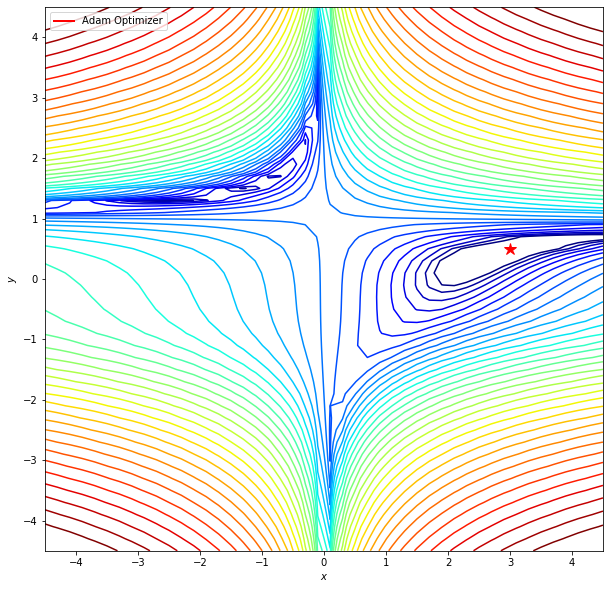

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=12)

line, = ax.plot([], [], 'r', label='Adam Optimizer', lw=2)
point, = ax.plot([], [], 'ro')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

In [43]:
import matplotlib.animation as manimation; manimation.writers.list()

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(*path_trace[::,:i])
    point.set_data(*path_trace[::,i-1:i])
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path_trace.shape[1], interval=60, 
                               repeat_delay=5, blit=True)
HTML(anim.to_html5_video())